## Introduction
In the current world, primary energy prices play an important role in affecting the stability of financial systems. In this project, we demonstrate the correlation between primary energy prices and several stock prices. Primary energy is crucial to many industries, and fluctuations in energy market can impact people’s prospect on near-future economy. Therefore, an 
interaction can be expected between stock market and energy market. In this project, we will focus on the influence of some factors in primary energy market on stock market index (or/and prices of certain stocks).We first gather the primary energy prices throughout history using an API from the United States Energy Information Administration (EIA). Then, we gather the stock data prices using the python package **alpha_vantage** and the corresponding API from alpha vantage. The analysis will include what are the most influential factors to the stock market in the energy market (such as the combination of energy price and energy usage), how these factors affect the stock market, and finally on the basis of this analysis, what we can infer 
or recommend to people who are trying to invest.

## Content

We use two pacakges in this project: **alpha_vantage** and **plotly**. Alpha_vantage is a package/API which can be used to gather stock prices data. Plotly is a powerful and interactive data visualization pacakge which is available as packages in various different programming languages including javascript, python, and R. 

We will cover the following topics in this project: 
- [Installing the libraries](#Installing-the-libraries)
- [Loading and Cleaning of Data: Energy](#Loading-and-Cleaning-of-Data:-Energy)
- [Loading and Cleaning of Data: Stock](#Loading-and-Cleaning-of-Data:-Stock)
- [Combination of Data and Visualization](#Combination-of-Data-and-Visualization)
- [Autocorrelation Analysis of Stock Prices](#Autocorrelation-Analysis-of-Stock-Prices)
- [Linear Regression to Correlate Energy and Stock Prices](#Linear-Regression-to-Correlate-Energy-and-Stock-Prices)
- [Stock Price Indicator with Energy Prices](#Stock-Price-Indicator-with-Energy-Prices)
- [Summary and Future Resources](#Summary-and-Future-Resources)

## Installing the libraries

Before getting started, we need to install the following two packages using 'pip'. 

    $ pip install plotly
    
    $ pip install alpha_vantage
    
As mentioned above, plotly helps us visualize the price data and alpha_vantage helps with getting the stock price data. 

## Loading and Cleaning of Data: Energy

In this part, we will first import historical primary energy prices for different energy sources from EIA (U.S. Energy Information Administration). 
1. For petroleum, we are using both daily West Texas Intermediate and daily Brent Spot Price, dollars/barrel; 
2. For natural gas, we are using Henry Hub Natural Gas Spot Daily prices, dollars/MBTU; 
3. And for coal, we are using quaterly United States commercial and institutional prices, dollars/short ton.

And we also get the averages for these price data

In [53]:
import io, time, json, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

# Change the renderer for displaying result in nbviewer
pio.renderer = 'notebook_connected'

We need an unique API key from EIA and specific codes for queries through this API. 

In [12]:
api_key_eia = '5b1e88425f6f89171505963d6e26696c'
queries = {'pet_wti': 'PET.RWTC.D', 'pet_brent': 'PET.RBRTE.D', 'gas': 'NG.RNGWHHD.D', 'coal': 'COAL.COST.US-8.Q'}

We then process the response from EIA and make the dataframe.

In [13]:
def eia_response_process(key, response):
    json_response = response.json()
    series = json_response['series'][0]['data']
    raw = {x[0]: {key: x[1]} for x in series}
    df = pd.DataFrame(raw).transpose()
    return df

In [14]:
energy_price = dict()
for key, value in queries.items():
    response = requests.get('http://api.eia.gov/series/?api_key={}&series_id={}'.format(api_key_eia, value))
    energy_price[key] = eia_response_process(key, response)

energy_price['coal'].tail(10)

coal
2002Q2   0.0
2002Q1   0.0
2001Q4   0.0
2001Q3   0.0
2001Q2   0.0
2001Q1   0.0
2000Q4   0.0
2000Q3   0.0
2000Q2   0.0
2000Q1   0.0

As we can see, coal prices are quarterly and only available since 2008 (with values from 2001 to 2008 being zero as shown above); thus, in our analysis, we will mainly focus the influence of prices of petroleum and natural gas. 

In [15]:
del energy_price['coal']

## Loading and Cleaning of Data: Stock
In this part, we will import stock price data for companies in certain industries, such as energy industry, chemical industry, and civil aviation. Instead of using API directly, we are using the API package provided by Alpha Vantage. With this API, we can get the historical daily stock prices for up to the last 20 years. We have installed this package above.

The list of companies we are fosusing on and their corresponding symbols are as follows:

| Company Name | Symbol | Industry | Country |
| --- | --- | --- | --- |
| __British Petroleum PLC__| BP | Energy | United Kingdoms |
| __Royal Dutch Shell PLC__ | RDS-A | Energy | Netherlands, United Kingdoms |
| __BASF SE__ | BASFY | Chemical | Germany |
| __Gazprom PAO__ | OGZPY | Energy | Russia |
| __Exxon Mobil Corporation__ | XOM | Energy and Chemical | United States |
| __American Electric Power Company Inc__ | AEP | Energy | United States |
| __Dow Chemical Company__ | DOW | Chemical | United States |
| __Delta Air Lines Inc__ | DAL | Aviation | United States |
| __United Airlines Holdings Inc__ | UAL | Aviation | United States |
| __PetroChina Company Limited__ | PTR | Energy | China |
| __China Petroleum & Chemical Corporation__ | SNP | Energy and Chemical | China |
| __China Southern Airlines Co Ltd__ | ZNH | Aviation | China |


We also need an unique API key for querying the alpha vantage API. We can gather the data needed for our purpose. 

In [32]:
from alpha_vantage.timeseries import TimeSeries
api_key_stock = '87O4L96O7DF5ZEWU'
ts = TimeSeries(key = api_key_stock, output_format = 'json')
companies = {'British Petroleum PLC': 'BP', 
             'Royal Dutch Shell PLC': 'RDS-A',
             'BASF SE': 'BASFY',
             'Gazprom PAO': 'OGZPY',
             'Exxon Mobil Corporation': 'XOM',
             'American Electric Power Company Inc': 'AEP',
             'Dow Chemical Company': 'DOW',
             'Delta Air Lines Inc': 'DAL',
             'United Airlines Holdings Inc': 'UAL',
             'PetroChina Company Limited': 'PTR',
             'China Petroleum & Chemical Corporation': 'SNP',
             'China Southern Airlines Co Ltd': 'ZNH'
            }

We can then process the response of alpha vantage stock price data

In [33]:
# Processing response of alpha vantage stock price data 
def stock_response_process(key, value):
    data, metadata = ts.get_daily(symbol = value, outputsize = 'full')
    raw = {i: {key: j['4. close']} for i, j in data.items()}
    df = pd.DataFrame(raw).transpose()
    return df

The following code will run quite slow because we cannot get many data from the API and have to stop for 1 second. (We have a limit of 5 calls per minute and 500 calls per day) 

In [35]:
stock_price = dict()
count = 1
for key, value in companies.items():
    stock_price[key] = stock_response_process(key, value)
    if count % 5 == 0:
        time.sleep(60)
    count += 1

In [36]:
for key in stock_price:
    stock_price[key][key] = stock_price[key][key].astype(float)

## Combination of Data and Visualization
In this part, we will combine all the collected data to a single dataframe, and visualize the time series of both energy and stock prices. 

The date information need to be paired with price information. We use the following function to pair them. 

In [37]:
# Parse data index
def parse_date_index(raw_data):
    new_data = dict()
    for key, value in raw_data.items():
        value.index = pd.to_datetime(value.index)
        new_data[key] = value
    df = pd.DataFrame()
    for key, value in new_data.items():
        df = df.join(value, how = 'outer')
    return df

In [38]:
energy = parse_date_index(energy_price)
stock = parse_date_index(stock_price)
energy.head()

pet_wti  pet_brent  gas
1986-01-02    25.56        NaN  NaN
1986-01-03    26.00        NaN  NaN
1986-01-06    26.53        NaN  NaN
1986-01-07    25.85        NaN  NaN
1986-01-08    25.87        NaN  NaN

In [39]:
stock.head()

British Petroleum PLC  Royal Dutch Shell PLC  BASF SE  \
1999-12-09                  61.44                    NaN      NaN   
1999-12-10                  60.62                    NaN      NaN   
1999-12-13                  60.00                    NaN      NaN   
1999-12-14                  59.44                    NaN      NaN   
1999-12-15                  60.69                    NaN      NaN   

            Gazprom PAO  Exxon Mobil Corporation  \
1999-12-09          NaN                    86.13   
1999-12-10          NaN                    82.81   
1999-12-13          NaN                    82.66   
1999-12-14          NaN                    82.38   
1999-12-15          NaN                    83.06   

            American Electric Power Company Inc  Dow Chemical Company  \
1999-12-09                                31.94                   NaN   
1999-12-10                                31.75                   NaN   
1999-12-13                                31.59                   NaN   
1999-12-14                                31.50                   NaN   
1999-12-15                                31.50                   NaN   

            Delta Air Lines Inc  United Airlines Holdings Inc  \
1999-12-09                  NaN                           NaN   
1999-12-10                  NaN                           NaN   
1999-12-13                  NaN                           NaN   
1999-12-14                  NaN                           NaN   
1999-12-15                  NaN                           NaN   

            PetroChina Company Limited  \
1999-12-09                         NaN   
1999-12-10                         NaN   
1999-12-13                         NaN   
1999-12-14                         NaN   
1999-12-15                         NaN   

            China Petroleum & Chemical Corporation  \
1999-12-09                                     NaN   
1999-12-10                                     NaN   
1999-12-13                                     NaN   
1999-12-14                                     NaN   
1999-12-15                                     NaN   

            China Southern Airlines Co Ltd  
1999-12-09                           11.69  
1999-12-10                           11.69  
1999-12-13                           11.38  
1999-12-14                           11.13  
1999-12-15                           11.13

In the following part, we are going to visualize both the stock and energy prices data. 

In [40]:
time_period_stock = stock.index

fig_stock = go.Figure()
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['British Petroleum PLC'], name='British Petroleum PLC'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['Royal Dutch Shell PLC'], name='Royal Dutch Shell PLC'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['BASF SE'], name='BASF SE'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['Gazprom PAO'], name='Gazprom PAO'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['Exxon Mobil Corporation'], name='Exxon Mobil Corporation'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['Dow Chemical Company'], name='Dow Chemical Company'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['Delta Air Lines Inc'], name='Delta Air Lines Inc'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['United Airlines Holdings Inc'], name='United Airlines Holdings Inc'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['PetroChina Company Limited'], name='PetroChina Compnay Limited'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['China Petroleum & Chemical Corporation'], name='China Petroleum & Chemical Corporation'))
fig_stock.add_trace(go.Scatter(x=time_period_stock, y=stock['China Southern Airlines Co Ltd'], name='China Southern Airlines Co Ltd'))

fig_stock.update_layout(title='Stock Price from 1990 to 2019 ($)',
                   xaxis_title='Time',
                   yaxis_title='Stock Price')


In [41]:
time_period_energy = energy.index

fig_energy = go.Figure([go.Scatter(x=time_period_energy, y=energy['pet_wti'], name='PET_WTI ($/barrel)'), 
                       go.Scatter(x=time_period_energy, y=energy['pet_brent'], name='PET_BRENT ($/barrel)'), 
                       go.Scatter(x=time_period_energy, y=energy['gas'], name='Natural Gas ($/1000ft^3)')])
# fig_energy.add_trace([go.Scatter(x=time_period_energy, y=energy['pet_wti'], name='PET_WTI ($/barrel)')])
# fig_energy.add_trace([go.Scatter(x=time_period_energy, y=energy['pet_brent'], name='PET_BRENT ($/barrel)')])
# fig_energy.add_trace([go.Scatter(x=time_period_energy, y=energy['gas'], name='Natural Gas ($/1000ft^3)')])
fig_energy.update_layout(title='Energy Price from 1980 to 2019',
                   xaxis_title='Time',
                   yaxis_title='Energy Price')

Because stocks sometimes does 'share split', which means that the price of the stock will decrease by several times (usually integer amount of times) and the amount of shares will increase by the same amount. We want to see if there is these kind of abnormal drops in our data because it will affect our following analysis. 

In [42]:
abnormal_fall = list()
for company, df in stock.items():
    temp = 0
    for i in df.index:
        ratio = 0
        try:
            ratio = temp / df[i]
            temp = df[i]
            if ratio >= 2:
                abnormal_fall.append((company, i, ratio))
        except:
            temp = df[i]
            
print(abnormal_fall)

[('BASF SE', Timestamp('2017-10-17 00:00:00'), 3.9840728100113765)]


There seem to be a 1:4 share split for BASF SE in 2017-10-17. Let's visualize this part of the stock price and see our correction to the stock price. 

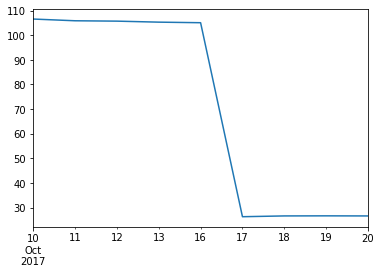

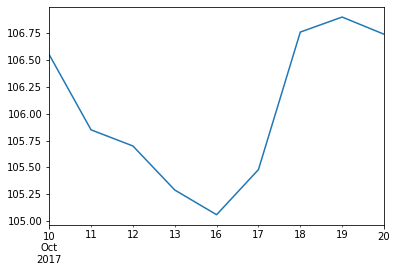

In [43]:
to_plot_2 = stock['BASF SE']['2017-10-10':'2017-10-20']
plt.figure()
to_plot_2.plot()
for company, date, ratio in abnormal_fall:
    stock[company][date:] = round(ratio) * stock[company][date:]
to_plot_2 = stock['BASF SE']['2017-10-10':'2017-10-20']
plt.figure()
to_plot_2.plot()

Indeed, after searching online, [there is a share split for BASF in 2017](https://topforeignstocks.com/2017/10/09/german-chemical-giant-basf-se-adr-stock-split-2017/). 

After cleaning all the data, we can join the two tables using inner join and see the resulting table. 

In [45]:
all_data = energy.join(stock, how = 'inner')
all_data

pet_wti  pet_brent   gas  British Petroleum PLC  \
1999-12-09    26.00      25.85   2.2                  61.44   
1999-12-10    25.21      24.86  2.27                  60.62   
1999-12-13    25.37      24.31  2.35                  60.00   
1999-12-14    25.87      24.88  2.49                  59.44   
1999-12-15    26.28      25.68  2.54                  60.69   
...             ...        ...   ...                    ...   
2019-12-03    56.15      62.95  2.42                  36.82   
2019-12-04    58.46      65.25  2.43                  37.06   
2019-12-05    58.42      65.67  2.42                  36.65   
2019-12-06    59.20      66.50  2.31                  37.09   
2019-12-09    58.99      66.44  2.17                  37.10   

            Royal Dutch Shell PLC  BASF SE  Gazprom PAO  \
1999-12-09                    NaN      NaN          NaN   
1999-12-10                    NaN      NaN          NaN   
1999-12-13                    NaN      NaN          NaN   
1999-12-14                    NaN      NaN          NaN   
1999-12-15                    NaN      NaN          NaN   
...                           ...      ...          ...   
2019-12-03                  56.21    74.84         7.70   
2019-12-04                  56.84    75.40         7.74   
2019-12-05                  56.49    75.36         7.67   
2019-12-06                  57.29    75.24         7.73   
2019-12-09                  57.27    74.66         7.74   

            Exxon Mobil Corporation  American Electric Power Company Inc  \
1999-12-09                    86.13                                31.94   
1999-12-10                    82.81                                31.75   
1999-12-13                    82.66                                31.59   
1999-12-14                    82.38                                31.50   
1999-12-15                    83.06                                31.50   
...                             ...                                  ...   
2019-12-03                    67.88                                90.88   
2019-12-04                    68.65                                92.03   
2019-12-05                    68.41                                92.46   
2019-12-06                    69.51                                92.39   
2019-12-09                    69.66                                91.86   

            Dow Chemical Company  Delta Air Lines Inc  \
1999-12-09                   NaN                  NaN   
1999-12-10                   NaN                  NaN   
1999-12-13                   NaN                  NaN   
1999-12-14                   NaN                  NaN   
1999-12-15                   NaN                  NaN   
...                          ...                  ...   
2019-12-03                 51.82                55.62   
2019-12-04                 52.28                56.06   
2019-12-05                 52.00                55.88   
2019-12-06                 53.22                56.14   
2019-12-09                 53.27                55.80   

            United Airlines Holdings Inc  PetroChina Company Limited  \
1999-12-09                           NaN                         NaN   
1999-12-10                           NaN                         NaN   
1999-12-13                           NaN                         NaN   
1999-12-14                           NaN                         NaN   
1999-12-15                           NaN                         NaN   
...                                  ...                         ...   
2019-12-03                         88.87                       45.28   
2019-12-04                         88.17                       45.74   
2019-12-05                         87.86                       45.34   
2019-12-06                         88.58                       45.91   
2019-12-09                         87.61                       46.13   

            China Petroleum & Chemical Corporation  \
1999-12-09                   

## Autocorrelation Analysis of Stock Prices
The reason we are doing  Autocorrelation analysis first is that we want to make sure whether we should add features containing infomation of some recent prices. Here we are applying ```plot_acf``` from ```statsmodels.graphics.tsaplots``` to directly observe the autocorrelation.

In [46]:
from statsmodels.graphics.tsaplots import plot_acf

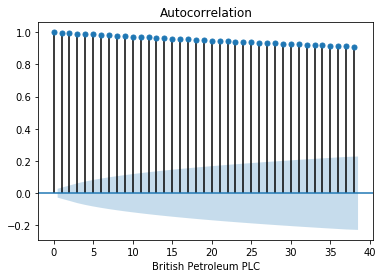

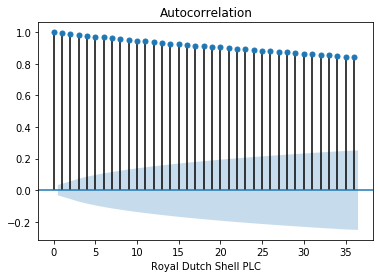

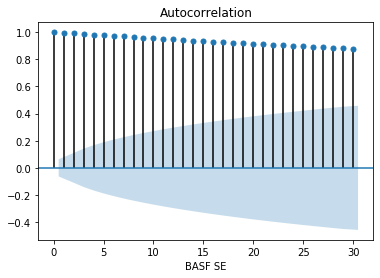

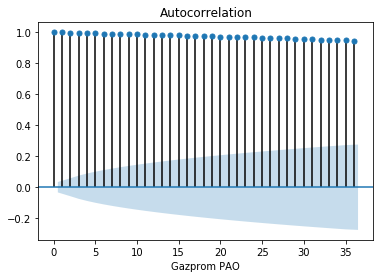

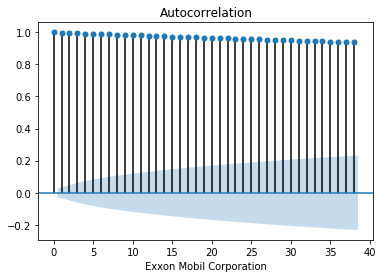

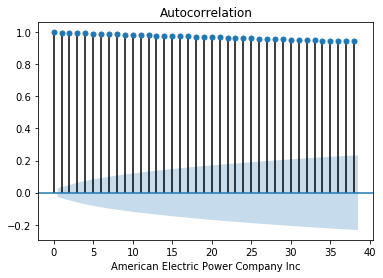

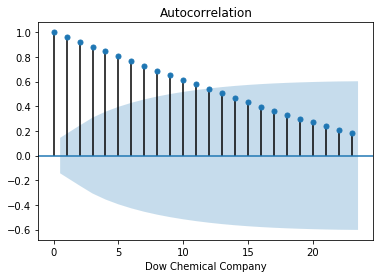

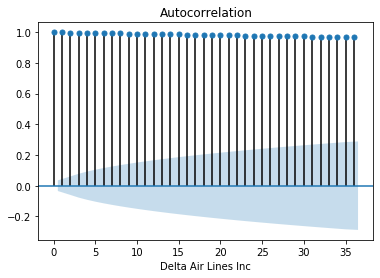

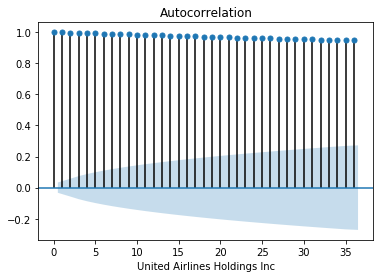

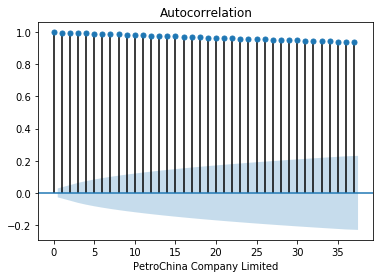

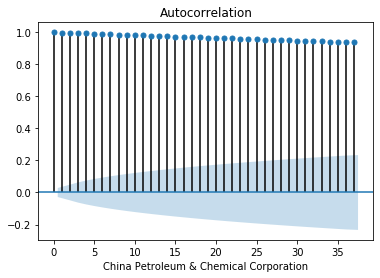

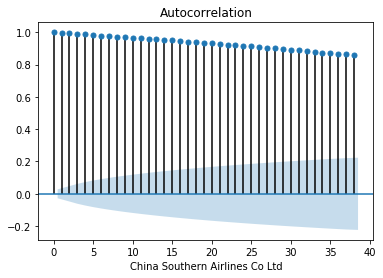

In [47]:
for key, df in stock.items():
    plot_acf(df.dropna())
    plt.xlabel(key)
    plt.show()

We can observe high autocorrelation with no transformation of the data. Then we can use first order differencing to further determine the most influencial datapoints.

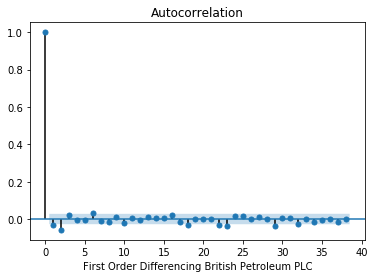

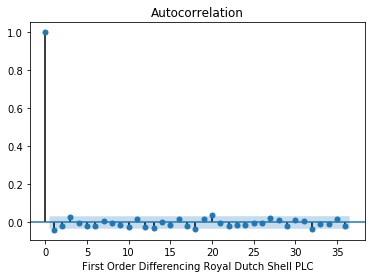

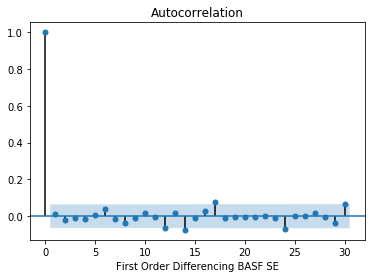

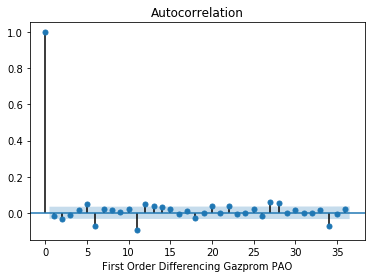

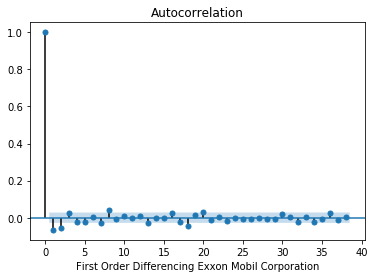

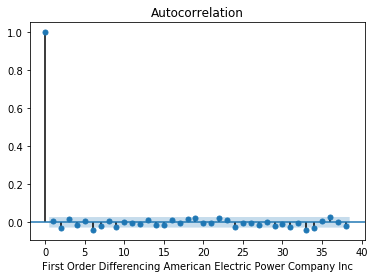

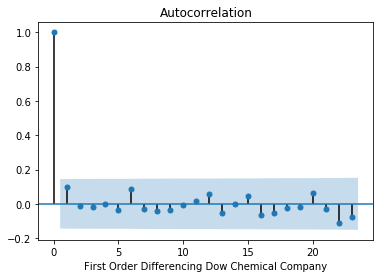

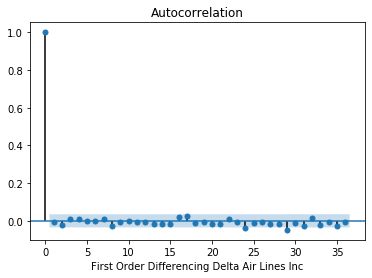

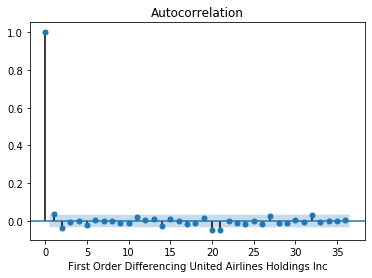

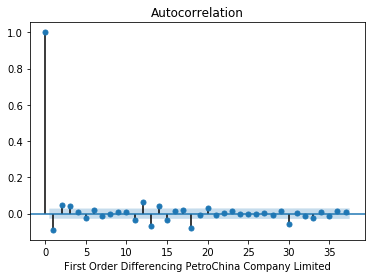

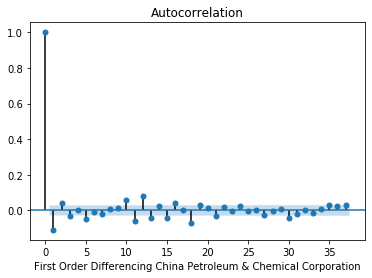

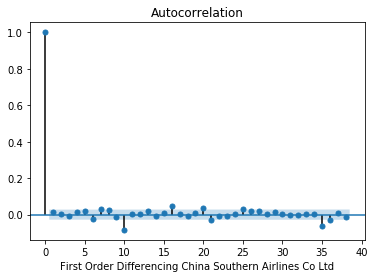

In [48]:
for key, df in stock.items():
    plot_acf(df.diff().dropna())
    plt.xlabel('First Order Differencing ' + key)
    plt.show()

As we can see, the only datapoint that still matters is the last one, so in our analysis, we will in all models include the last datapoint as one of the features.

## Linear Regression to Correlate Energy and Stock Prices

In this section, we are going to demonstrate how different stock prices are related to primary energy prices by using simple linear regressions. The features are the price of natural gas and oil. The prediction will be made to the stock prices. 

In [49]:
# generate a constant column in the all_data dataframe
all_data['const'] = np.ones(shape=(all_data['British Petroleum PLC'].shape[0], 1))

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
pd.options.mode.chained_assignment = None


def perform_lr(company, df=all_data, test_size=0.3, wti=False, squared_price=False): 
    '''Company can be 'British Petroleum PLC' 'Royal Dutch Shell PLC' 'BASF SE' 
    'Gazprom PAO' 'Exxon Mobil Corporation'  'American Electric Power Company Inc'
    'Dow Chemical Company' 'Delta Air Lines Inc' 'United Airlines Holdings Inc'
    'PetroChina Company Limited' 'China Petroleum & Chemical Corporation'
    'China Southern Airlines Co Ltd'    
    '''
    
    if not squared_price: 
        if not wti: 

            # drop any column with NaN within the company
            new_df = df.dropna(axis=0, subset=['pet_brent', 'gas', company])
            X = np.array(new_df[['pet_brent', 'gas', 'const']], dtype='float64')
            y = np.array(new_df[company], dtype='float64').reshape(X.shape[0], 1)       
        else: 
            new_df = df.dropna(axis=0, subset=['pet_wti', 'gas', company])
            X = np.array(new_df[['pet_wti', 'gas', 'const']], dtype='float64')
            y = np.array(new_df[company], dtype='float64').reshape(X.shape[0], 1)  
            
    else: 
        if not wti: 
            # drop any column with NaN within the company
            new_df = df.dropna(axis=0, subset=['pet_brent', 'gas', company])
            squared_oil = new_df['pet_brent']**2
            new_df['pet_brent_sq'] = squared_oil
            new_df['gas_sq'] = new_df['gas']**2
            
            X = np.array(new_df[['pet_brent', 'gas', 'pet_brent_sq', 'gas_sq', 'const']], dtype='float64')
            y = np.array(new_df[company], dtype='float64').reshape(X.shape[0], 1)    
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, shuffle=True, test_size=0.3)
    
    p = np.linalg.solve(train_X.T @ train_X, train_X.T @ train_y)
    
    return p, company, test_X, test_y

def calculate_score(p, test_X, test_y):
    pred = test_X @ p
    r_squared = r2_score(test_y, pred)
    return r_squared


scores = {}

for j, name in enumerate(list(stock.columns)): 
    p, _, test_X, test_y = perform_lr(name)
    r_squared = calculate_score(p, test_X, test_y)
    scores[name] = r_squared

scores_sq = {}

for j, name in enumerate(list(stock.columns)): 
    p_sq, _, test_X_sq, test_y_sq = perform_lr(name, squared_price=True)
    r_squared_sq = calculate_score(p_sq, test_X_sq, test_y_sq)
    scores_sq[name] = r_squared_sq    

fig = go.Figure([go.Bar(name='No squared energy prices', x=list(scores.keys()), y=list(scores.values())), 
                go.Bar(name='With squared energy prices', x=list(scores_sq.keys()), y=list(scores_sq.values()))])

fig.update_layout(barmode='group', title='R-sqaured values for Simple Linear Regression',
                   xaxis_title='Company',
                   yaxis_title='R-sqaured')
fig.show()    

From the plot shown above, we can conclude that the large, state-owned companies correlate with the primary energy prices the best (**Gazprom PAO** is the largest Russian oil and gas Company, **PetroChina Company Limited** and **China Petroleum & Chemical Corporation** are the two large state-owned oil and gas companies in China). Adding the squared energy prices seem to improve the model in terms of R-squared values. The US-based commericial aviation companies (**United Airlines Holdings Inc** and **Delta Air Lines Inc**) seem to correlate much better with primary energy prices compared to the China-based commercial aviation company (**China Southern Airlines Co Ltd**). Another company that does not correlate well with primary energy prices is **BASF SE**, which manufactures various chemicals and may not be as dependent on primary energies as the other companies in this list. 

## Stock Price Indicator with Energy Prices
To forecast the precise stock price is a hard problem due to its inherent uncertainty. A relaxed problem can be to predict the rise and fall of stock prices. Thus in the following part,  we will use an SVM to do the job.

One challenge is to determine the features that can be used in the analysis:
1. As we care most about the influence of the energy prices, they will be the first set of features; 
2. Previous stock prices are also influential to the latter data points, and they will be the second set of features; 
3. The stock market index is also a very important feature, and as we are not collecting any extant stock market index, stock prices of other companies in the same industry as a "pseudo market index".

In [50]:
info_companies = {'British Petroleum PLC': {'symbol' : 'BP', 'industry' : ['Energy'], 'country' : ['United Kingdoms']}, 
                 'Royal Dutch Shell PLC': {'symbol' : 'RDS-A', 'industry' : ['Energy'], 'country' : ['Netherland', 'United Kingdoms']},
                 'BASF SE': {'symbol' : 'BASFY', 'industry' : ['Chemical'], 'country' : ['Germany']},
                 'Gazprom PAO': {'symbol' : 'OGZPY', 'industry' : ['Energy'], 'country' : ['Russia']},
                 'Exxon Mobil Corporation': {'symbol' : 'XOM', 'industry' : ['Energy', 'Chemical'], 'country' : ['United States']},
                 'American Electric Power Company Inc': {'symbol' : 'AEP', 'industry' : ['Energy'], 'country' : ['United States']},
                 'Dow Chemical Company': {'symbol' : 'DOW', 'industry' : ['Chemical'], 'country' : ['United States']},
                 'Delta Air Lines Inc': {'symbol' : 'DAL', 'industry' : ['Aviation'], 'country' : ['United States']},
                 'United Airlines Holdings Inc': {'symbol' : 'UAL', 'industry' : ['Aviation'], 'country' : ['United States']},
                 'PetroChina Company Limited': {'symbol' : 'PTR', 'industry' : ['Energy'], 'country' : ['China']},
                 'China Petroleum & Chemical Corporation': {'symbol' : 'SNP', 'industry' : ['Energy', 'Chemical'], 'country' : ['China']},
                 'China Southern Airlines Co Ltd': {'symbol' : 'ZNH', 'industry' : ['Aviation'], 'country' : ['China']},
                 }
df_companies = pd.DataFrame(info_companies).transpose()

In [60]:
from sklearn import svm
from sklearn.model_selection import train_test_split

def indicator_features_creation(company, all_data = all_data, df_companies = df_companies, lag = 5):
    new_df = pd.DataFrame()
    # add energy prices
    new_df = new_df.join(all_data['pet_brent'], how = 'outer')
    new_df = new_df.join(all_data['pet_wti'], how = 'inner')
    new_df = new_df.join(all_data['gas'], how = 'inner')
    
    # add previous stock prices in the same industry
    industry = df_companies['industry'][company]
    for i in df_companies.index:
        other = df_companies['industry'][i]
        if other == industry:
            x = all_data[i].shift(1).dropna()
            new_df = new_df.join(x, how = 'inner')
    
    # add previous stock prices of the same company
    for i in range(2, lag + 1):
        x = all_data[company].shift(i).dropna()
        new_df = new_df.join(x, how = 'inner', lsuffix = ' ' + str(i) + ' lags')
    
    # add dependent variable
    y = all_data[company].diff().dropna()
    for i in y.index:
        if y[i] >= 0:
            y[i] = 1
        else:
            y[i] = 0
    new_df = new_df.join(y, how = 'inner', rsuffix = ' indicator')
    return new_df.dropna()

def train_test(features, shuffle = True, test_size = 0.4):
    train_test = train_test_split(features, shuffle = shuffle, test_size = test_size)
    train = train_test[0]
    test = train_test[1]
    X_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]
    X_test = test.iloc[:, :-1]
    y_test = test.iloc[:, -1]
    return X_train, y_train, X_test, y_test

def apply_SVM(X_train, y_train, X_test, y_test):
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    results_train = clf.predict(X_train)
    gt_train = np.asarray(y_train)
    errors_train = abs(results_train - gt_train)
    error_rate_train = np.sum(errors_train) / errors_train.shape[0]
    results_test = clf.predict(X_test)
    gt_test = np.asarray(y_test)
    errors_test = abs(results_test - gt_test)
    error_rate_test = np.sum(errors_test) / errors_test.shape[0]
   #  print('Training Error: {}\nTest Error: {}'.format(error_rate_train, error_rate_test))
    return clf, error_rate_train, error_rate_test

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [71]:
features = indicator_features_creation('Gazprom PAO')
X_train, y_train, X_test, y_test = train_test(features)
clf = apply_SVM(X_train, y_train, X_test, y_test)

train_error_list = []
test_error_list = []

for i in range(1, 21):
    features = indicator_features_creation('PetroChina Company Limited', lag=i)
    X_train, y_train, X_test, y_test = train_test(features)
    clf, error_train, error_test = apply_SVM(X_train, y_train, X_test, y_test)
    train_error_list += [error_train]
    test_error_list += [error_test]


Text(0, 0.5, 'Error')

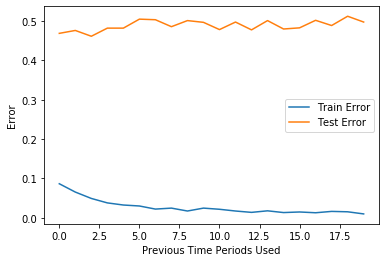

In [76]:
plt.plot(train_error_list, label = 'Train Error')
plt.plot(test_error_list, label = 'Test Error')
plt.legend()
plt.xlabel('Previous Time Periods Used')
plt.ylabel('Error')

As we can see from the figure above, for one of the most correlated companies in the list, the test error of the SVM approach for this problem will not change much from increasing the 'lag' (the number of data points from previous time periods). Our approach can only do a little bit better than random guess. This result shows that although some of the stocks tested are highly correlated with the price of primary energy sources, it is almost impossible to predict the stock price based on the combination of stock prices at previous time periods and energy prices. 

## Summary and Future Resources

In this project, we first loaded and visualized the stock price data. We then performed an autocorrelation study of the stock prices because we want to make sure whether we should add features containing infomation of some recent prices. After the autocorrelation analysis, we did a linear regression to correlate stock and energy prices and found that large, state-owned companies correlate with the primary energy prices the best. Finally, we attempted to use an SVM approach to model the stock price based on energy price, the average price of the same stock at previous time, and the market price indicated by the average of all stock prices collected. Some future resources are shown below. 

1. Plotly: https://plot.ly/python/
2. Energy Information Administration: https://www.eia.gov/
3. Alpha Vantage API Documentation: https://www.alphavantage.co/documentation/
4. Autocorrelation with Statsmodel: https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html